# Time Series Exploration  

## Background

Adapted from [A comprehensive beginner’s guide to create a Time Series Forecast (with Codes in Python)](https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/)
<br><br>
The purpose of this notebook is to better understand Time Series and Time Series maniuplation in Python. Several methods to confirm stationarity will be introduced followed by a comparative implementation of two models for Time Series forecasting.<br>
The [dataset](https://www.analyticsvidhya.com/wp-content/uploads/2016/02/AirPassengers.csv) being used will be for the number of airline passengers per year from 1949-1961.
<br>
The ARIMA model will be used to forecast as well as SKLearn's LinearRegression function as comparison.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
%config InlineBackend.figure_format = 'retina'

## Get Data

We can read data directly from a url as so:

In [101]:
data = pd.read_csv("https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv")

### Load Data and Visualize

Now, we can load the data set and look at some initial rows and data types of the columns:

In [102]:
# Visual as DataFrame
print(data.head())
print('\n Data Types:')
print(data.dtypes)

     Month  #Passengers
0  1949-01          112
1  1949-02          118
2  1949-03          132
3  1949-04          129
4  1949-05          121

 Data Types:
Month          object
#Passengers     int64
dtype: object


Need to convert to a Time Series object.<br>
Currently, data types are:<br>
**Month** `object`<br>
**#Passengers** `int64`
<br><br>
Need Data type **datetime64[ns]**

In [42]:
dateparse = lambda dates: pd.datetime.strptime(dates, 
                                               '%Y-%m')
data = pd.read_csv('AirPassengers.csv', 
                   parse_dates=['Month'], # parses column with datetime info
                   index_col='Month',     # specifies the index column
                   date_parser=dateparse) # converts string to datetime var
data.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


Let’s understand the arguments one by one:

**parse_dates**: This specifies the column which contains the date-time information. As we say above, the column name is ‘Month’.   

**index_col**: A key idea behind using Pandas for TS data is that the index has to be the variable depicting date-time information. So this argument tells pandas to use the ‘Month’ column as index.   

**date_parser**: This specifies a function which converts an input string into datetime variable. Be default Pandas reads data in format ‘YYYY-MM-DD HH:MM:SS’. If the data is not in this format, the format has to be manually defined.   

Something similar to the dataparse function defined here can be used for this purpose.
Now we can see that the data has time object as index and #Passengers as the column. 

We can cross-check the datatype of the index with the following command:

In [43]:
data.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [44]:
ts = data['#Passengers']
ts.head(10)

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
1949-07-01    148
1949-08-01    148
1949-09-01    136
1949-10-01    119
Name: #Passengers, dtype: int64

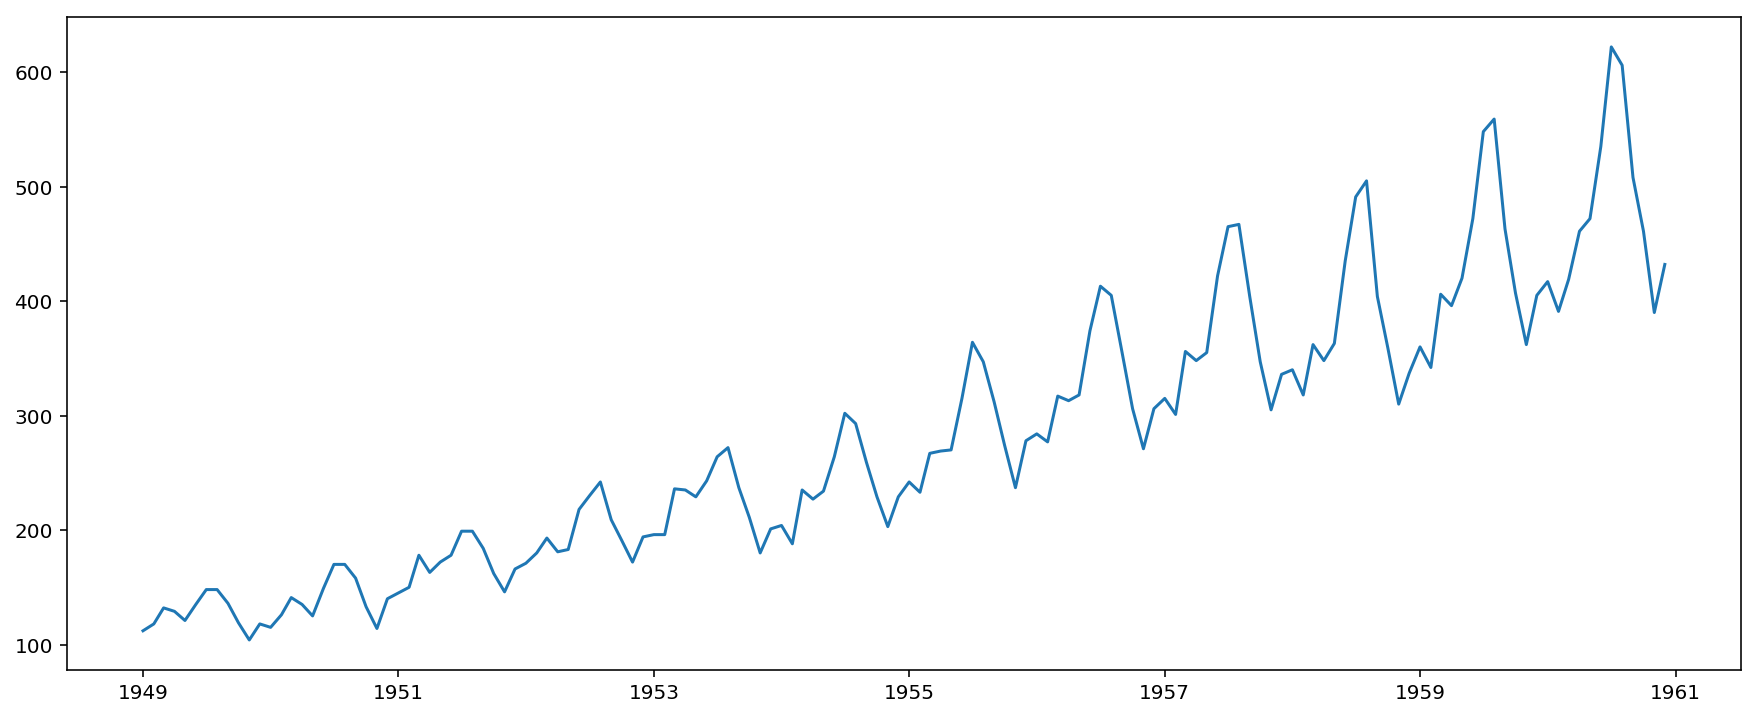

In [47]:
plt.plot(ts);

# Stationarity

## Check if Stationary

Using Rolling Mean and Rolling Standard Deviation
<br><br>
Also verify using **Dickey-Fuller Test** which defines confidence levels assuming non-stationary.<br>
If *Test Statistic* < *Critical Value* then series is stationary.<br>
[Reference](https://www.analyticsvidhya.com/blog/2015/12/complete-tutorial-time-series-modeling/)

A TS is said to be stationary if its statistical properties such as mean, variance remain constant over time. But why is it important? Most of the TS models work on the assumption that the TS is stationary. Intuitively, we can sat that if a TS has a particular behaviour over time, there is a very high probability that it will follow the same in the future. Also, the theories related to stationary series are more mature and easier to implement as compared to non-stationary series.

Stationarity is defined using very strict criterion. However, for practical purposes we can assume the series to be stationary if it has constant statistical properties over time, ie. the following:

constant mean
constant variance
an autocovariance that does not depend on time.
I’ll skip the details as it is very clearly defined in this article. Lets move onto the ways of testing stationarity. First and foremost is to simple plot the data and analyze visually. The data can be plotted using following command:

In [63]:
from pandas.core import datetools

def test_stationarity(timeseries):
    # Determining rolling statistics
    rol_mean = timeseries.rolling(window=12, center=False).mean()
    rol_std = timeseries.rolling(window=12, center=False).std()
    
    # Plot rolling statistics:
    orig = plt.plot(timeseries, color='b', label='Original')
    mean = plt.plot(rol_mean, color='r', label='Rolling Mean')
    std = plt.plot(rol_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',
                                             'p-value',
                                             '#Lags Used',
                                             'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

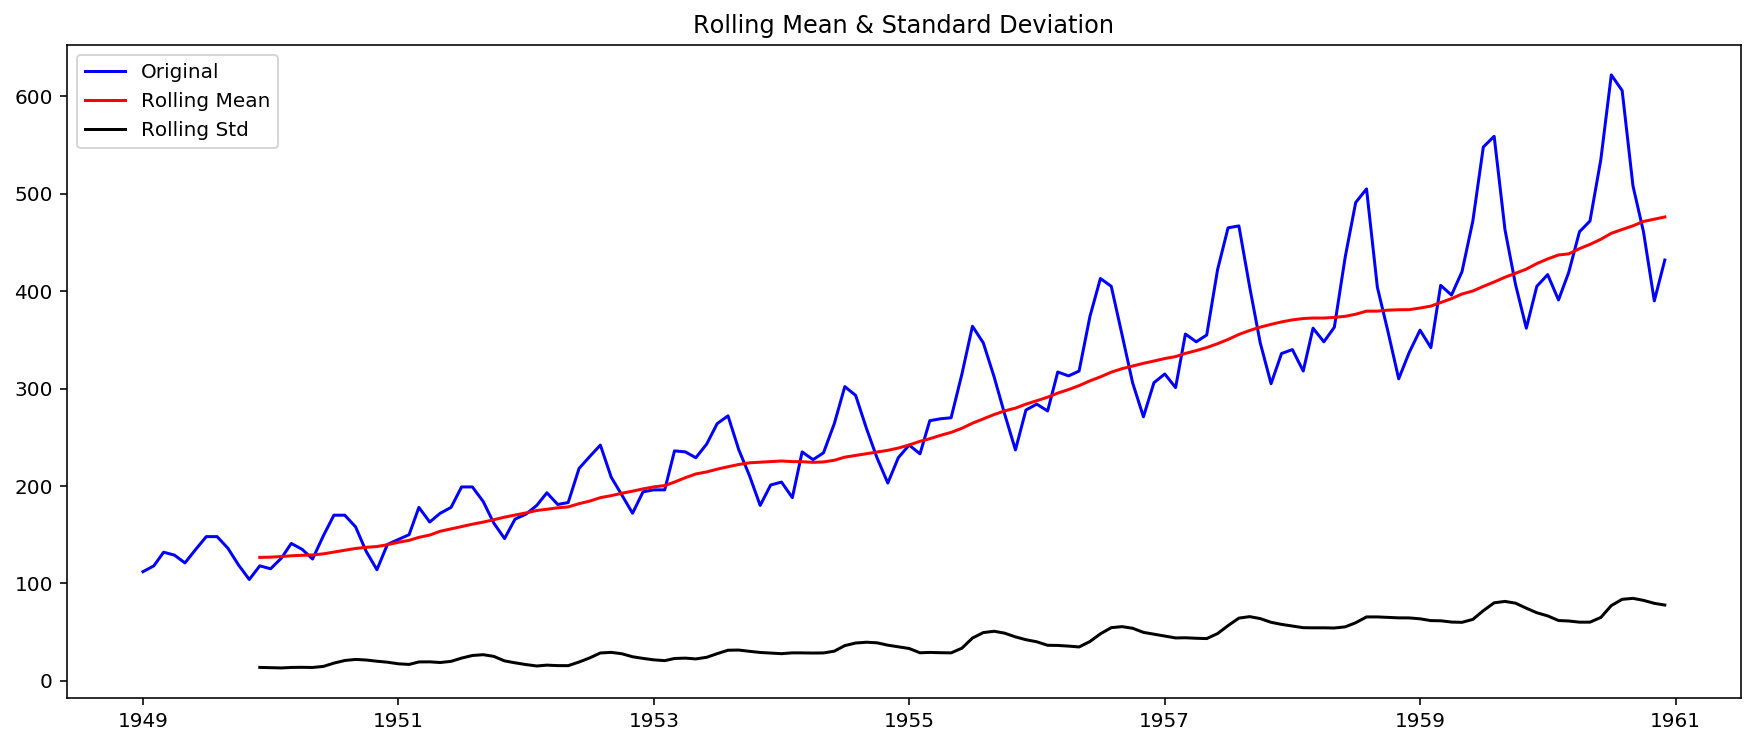

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [64]:
test_stationarity(ts)

It is clearly evident that there is an overall increasing trend in the data along with some seasonal variations. However, it might not always be possible to make such visual inferences (we’ll see such cases later). So, more formally, we can check stationarity using the following:

1. **Plotting Rolling Statistics:** We can plot the moving average or moving variance and see if it varies with time. By moving average/variance I mean that at any instant ‘t’, we’ll take the average/variance of the last year, i.e. last 12 months. But again this is more of a visual technique.

2. **Dickey-Fuller Test:** This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary. Refer this article for details.

Although the variation in standard deviation is small, mean is clearly increasing with time and this is not a stationary series. Also, the test statistic is way more than the critical values. Note that the signed values should be compared and not the absolute values.

Next, we’ll discuss the techniques that can be used to take this TS towards stationarity.

## Make Time Series Stationary

Though stationarity assumption is taken in many TS models, almost none of practical time series are stationary. So statisticians have figured out ways to make series stationary, which we’ll discuss now. Actually, its almost impossible to make a series perfectly stationary, but we try to take it as close as possible.

Lets understand what is making a TS non-stationary. There are 2 major reasons behind non-stationaruty of a TS:
1. Trend – varying mean over time. For eg, in this case we saw that on average, the number of passengers was growing over time.
2. Seasonality – variations at specific time-frames. eg people might have a tendency to buy cars in a particular month because of pay increment or festivals.

The underlying principle is to model or estimate the trend and seasonality in the series and remove those from the series to get a stationary series. Then statistical forecasting techniques can be implemented on this series. The final step would be to convert the forecasted values into the original scale by applying trend and seasonality constraints back.

Note: I’ll be discussing a number of methods. Some might work well in this case and others might not. But the idea is to get a hang of all the methods and not focus on just the problem at hand.

Let’s start by working on the trend part.

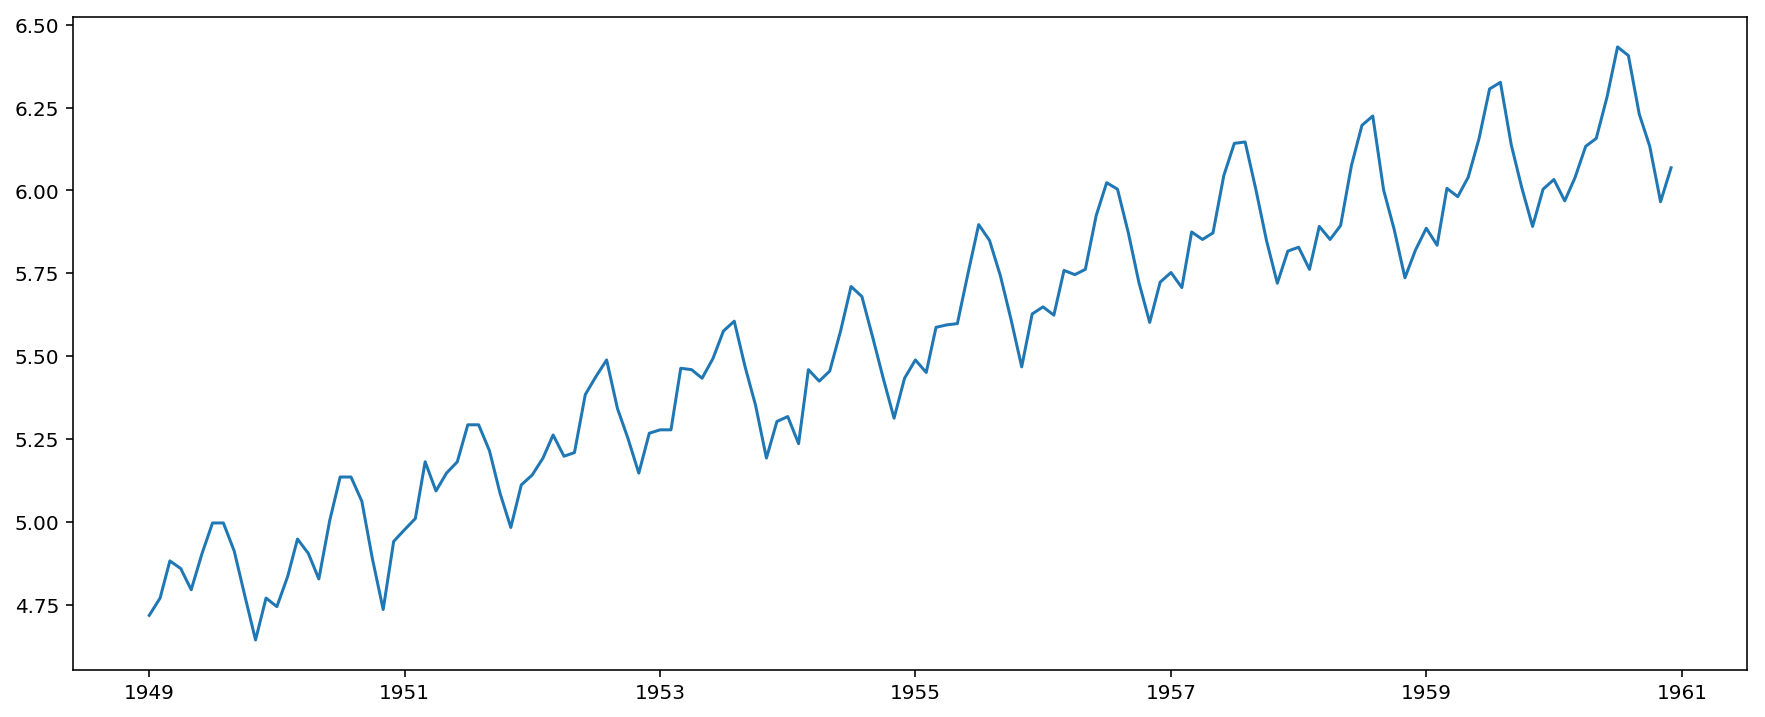

In [71]:
# Get the natural log of the time series
ts_log = np.log(ts)
plt.plot(ts_log);

In this simpler case, it is easy to see a forward trend in the data. But its not very intuitive in presence of noise. So we can use some techniques to estimate or model this trend and then remove it from the series.  There are several ways we can make the data stationary:

1. **Smoothing** - taking rolling averages  
2. **Aggregation** - taking average for time period (such as monthly/weekly averages)    
3. **Polynomial Fitting** - fitting a regression model

### Smoothing

We can use pandas `rolling` function to find the rolling mean (or standard deviation).   
Let's find that rolling mean and plot it on the same axis as our original time series.

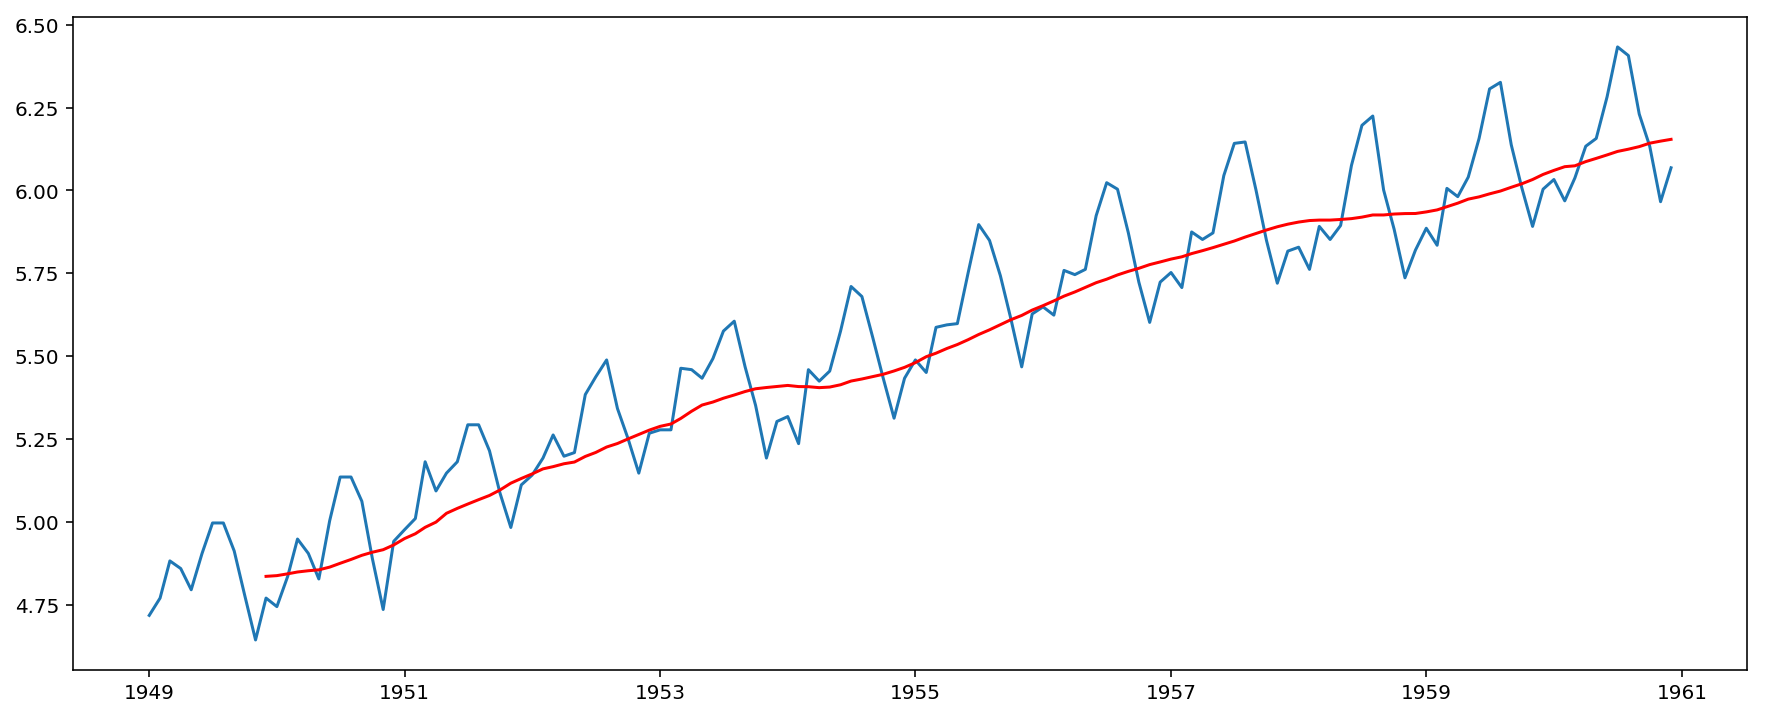

In [69]:
moving_avg = ts_log.rolling(window=12, center=False).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='r');

Note that there is no rolling average for the first 11 values, this can be shown by getting the difference between the original Series and its rolling average.<br>

These NaN values should be dropped to properly test stationarity.

In [72]:
difference = ts_log - moving_avg
difference.head(13)

Month
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01         NaN
1949-08-01         NaN
1949-09-01         NaN
1949-10-01         NaN
1949-11-01         NaN
1949-12-01   -0.065494
1950-01-01   -0.093449
Name: #Passengers, dtype: float64

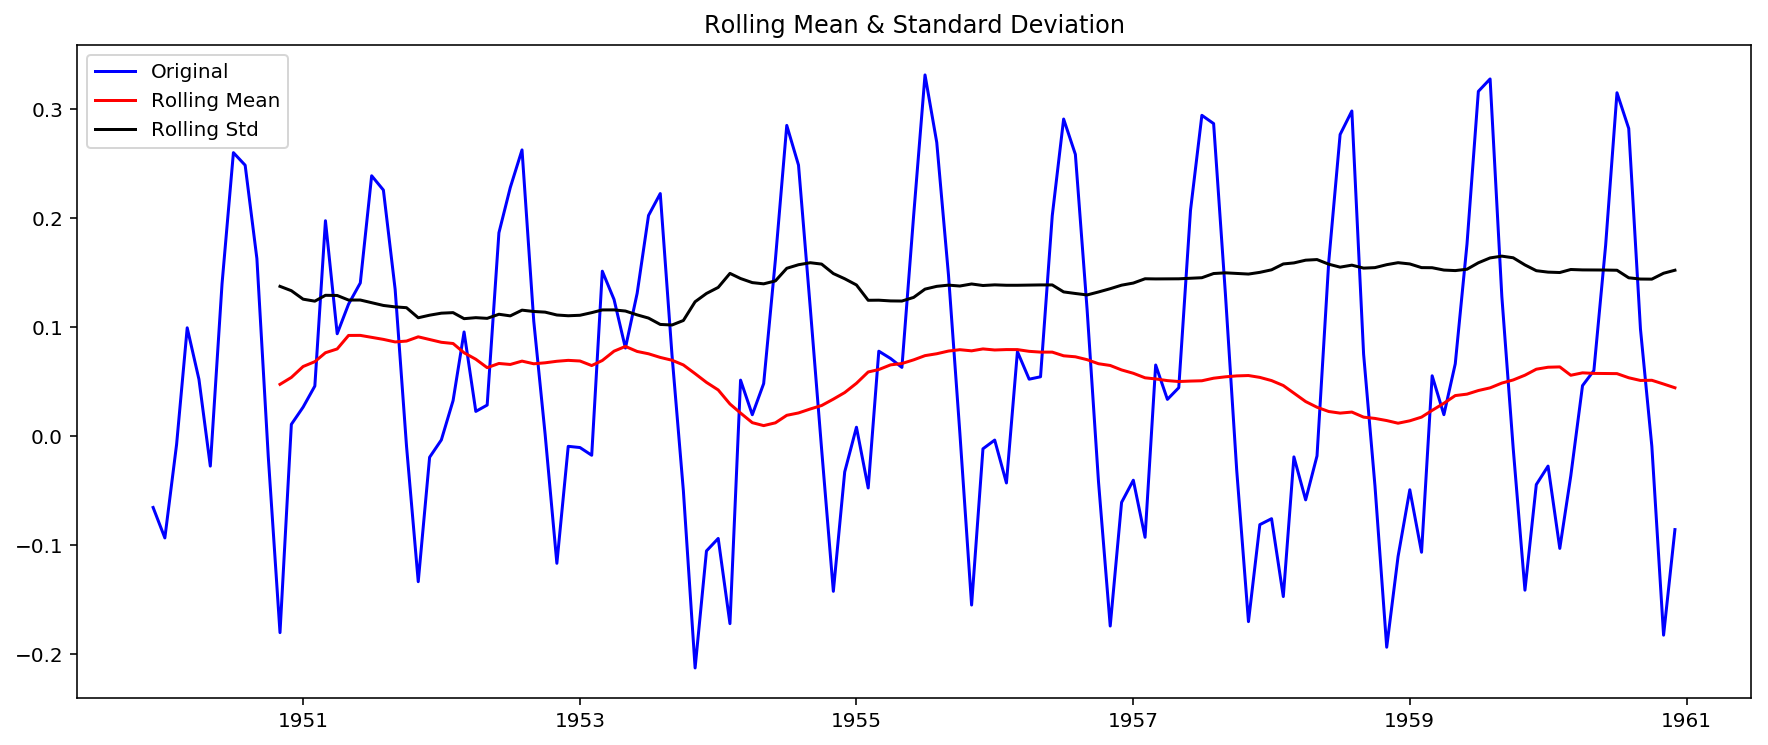

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [73]:
difference.dropna(inplace=True)
test_stationarity(difference)

### Weighted Moving Average

For above, the time period needs to be *strictly defined*. To overcome this, use a **weighted moving average**. In this particular case, using `exponentially weighted moving average` which is detailed [here](http://pandas.pydata.org/pandas-docs/stable/computation.html#exponentially-weighted-windows). This will have no missing values since all values are given weights (versus smoothing which only needed `.dropna()`).



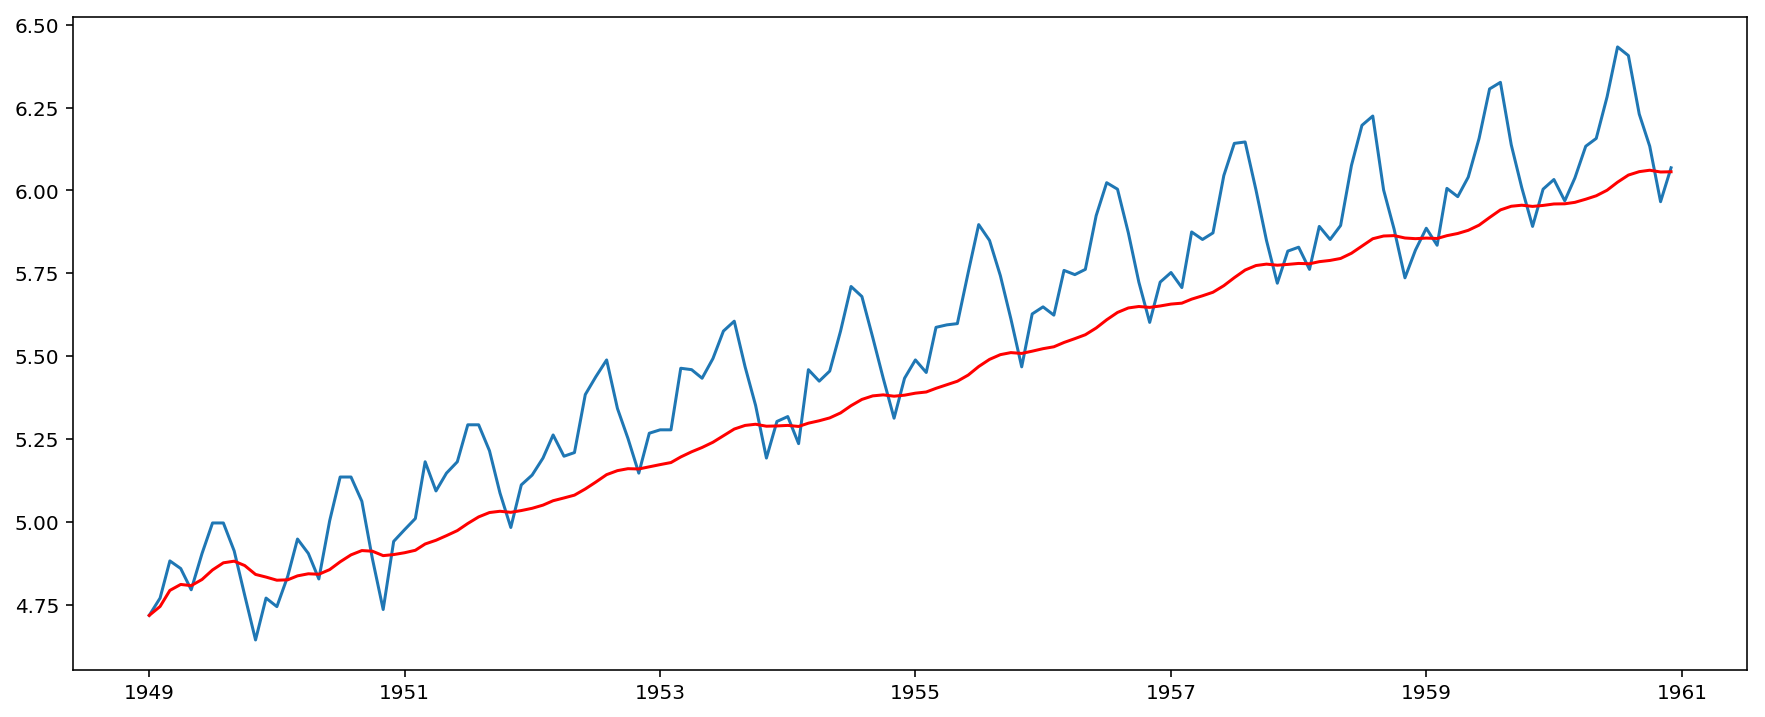

In [80]:
# Use exponentially weighted moving average
#ewma = pd.ewma(ts_log, halflife=12)
ewma = ts_log.ewm(halflife=12, min_periods=0,adjust=True,ignore_na=False).mean()
plt.plot(ts_log)
plt.plot(ewma, color='r');

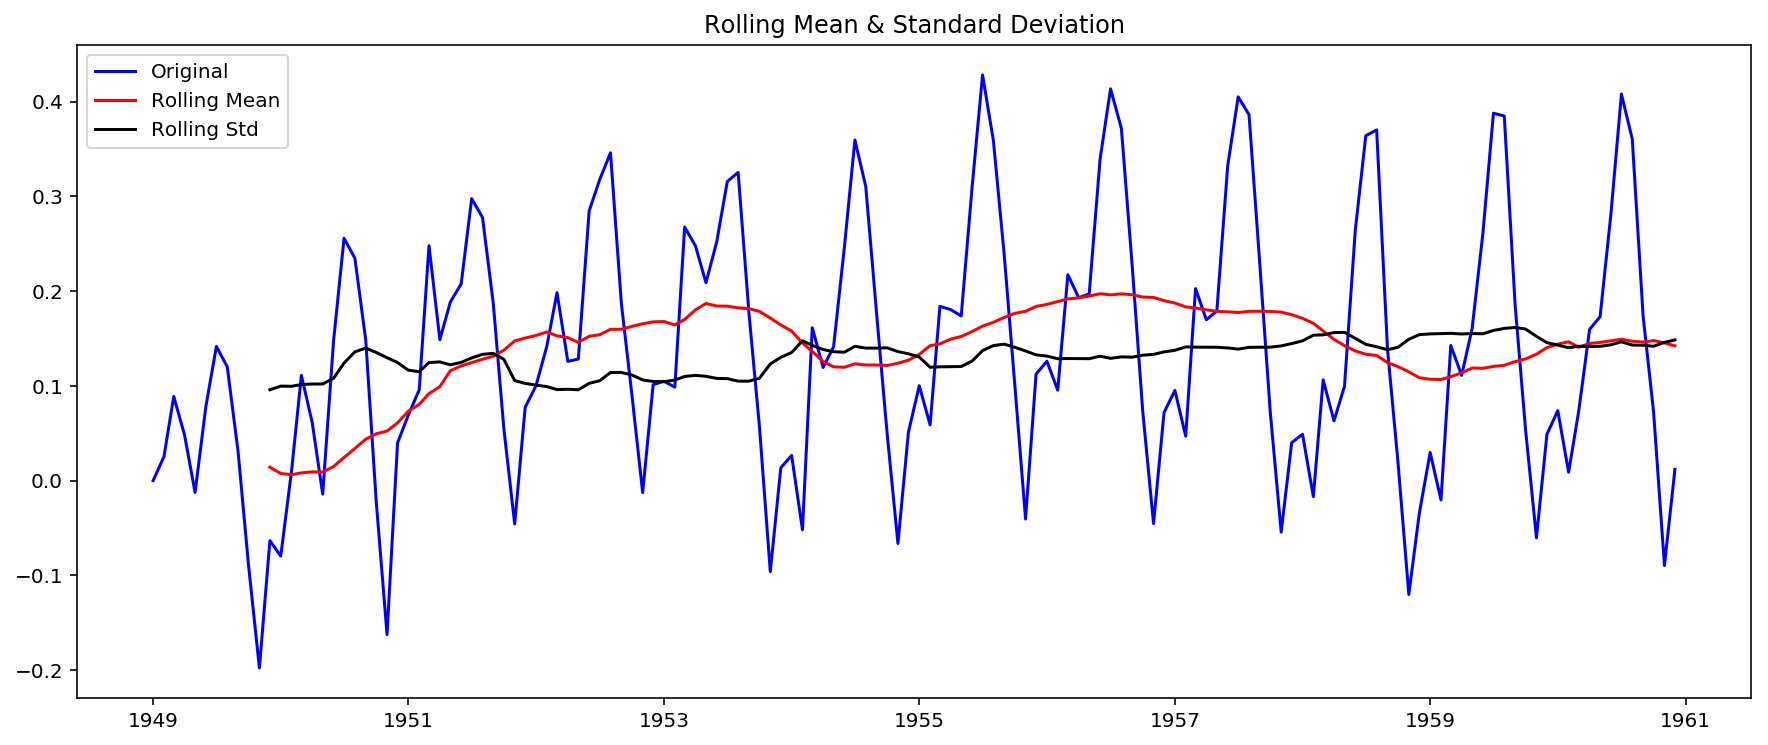

Results of Dickey-Fuller Test:
Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [76]:
difference_ewma = ts_log - ewma
test_stationarity(difference_ewma);

## Eliminating Trend and Seasonality

**Decomposing** to model trend and seasonality and remove them from the model

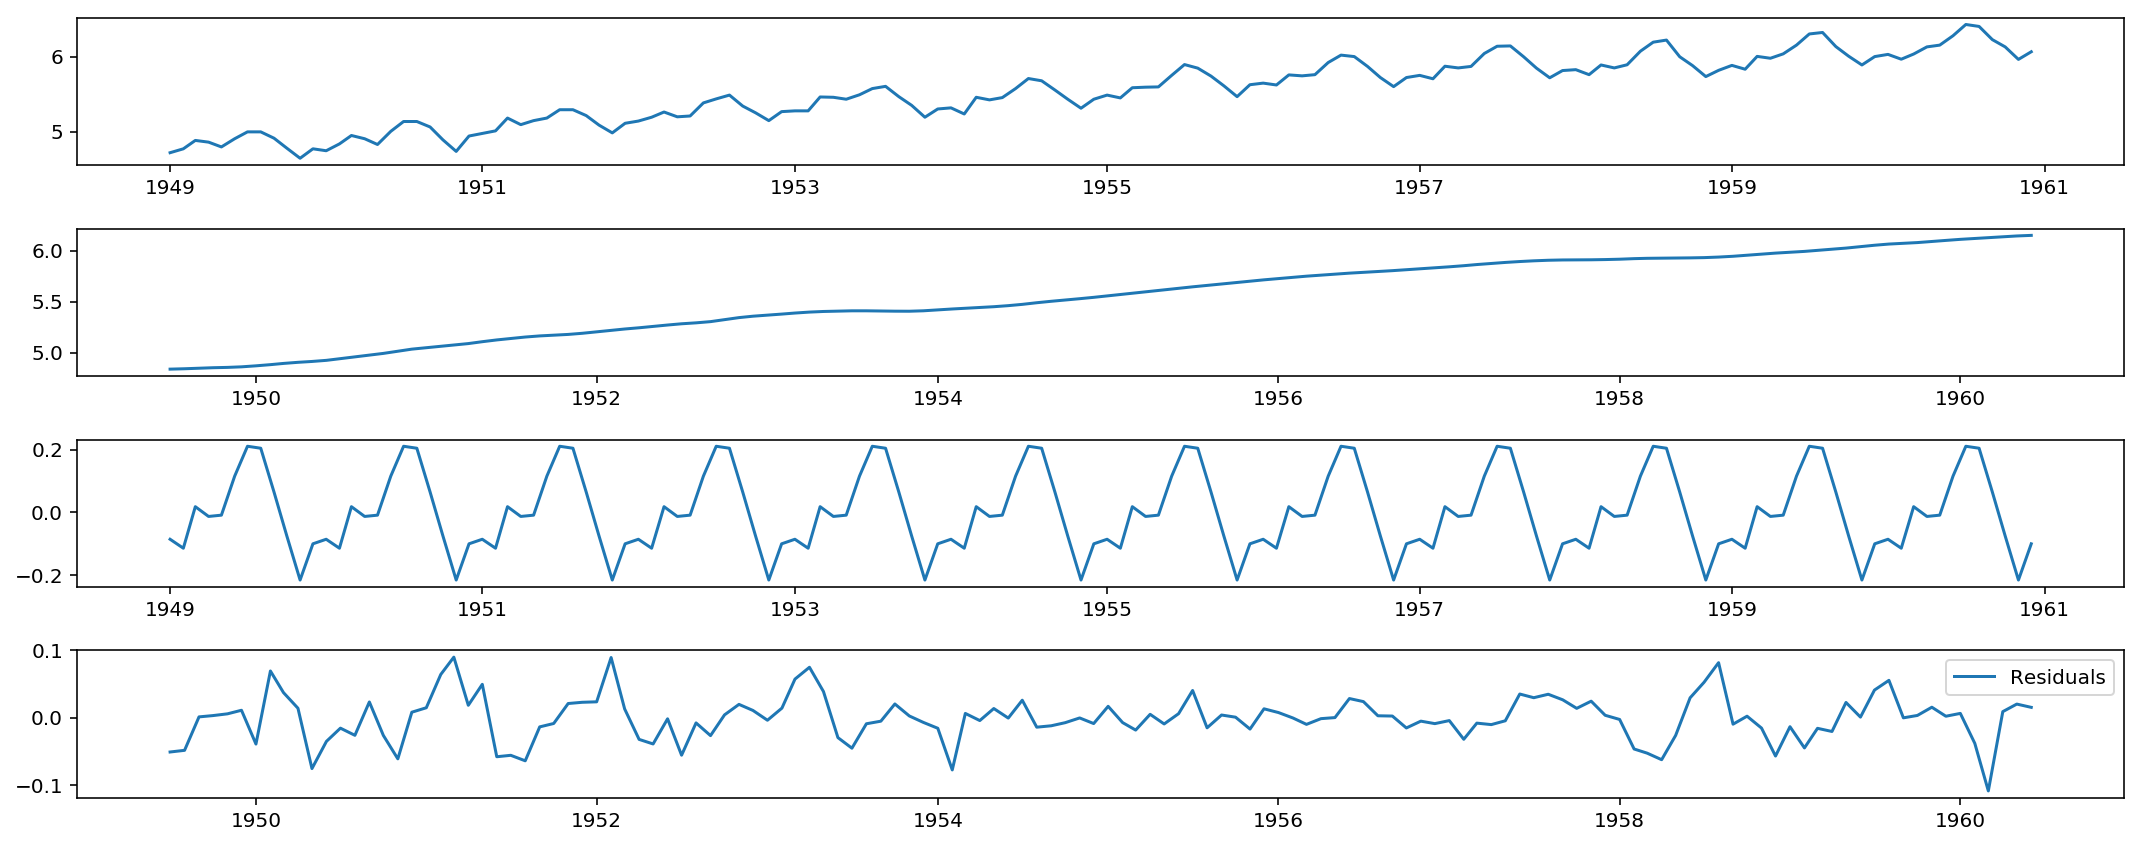

In [108]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomp = seasonal_decompose(ts_log)
trend = decomp.trend
seasonal = decomp.seasonal
residual = decomp.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')

plt.subplot(412)
plt.plot(trend, label='Trend')

plt.subplot(413)
plt.plot(seasonal, label='Seasonality')

plt.subplot(414)
plt.plot(residual, label='Residuals')

plt.legend(loc='best')
plt.tight_layout()

Here we can see that the trend, seasonality are separated out from data and we can model the residuals.  
Lets check stationarity of residuals:

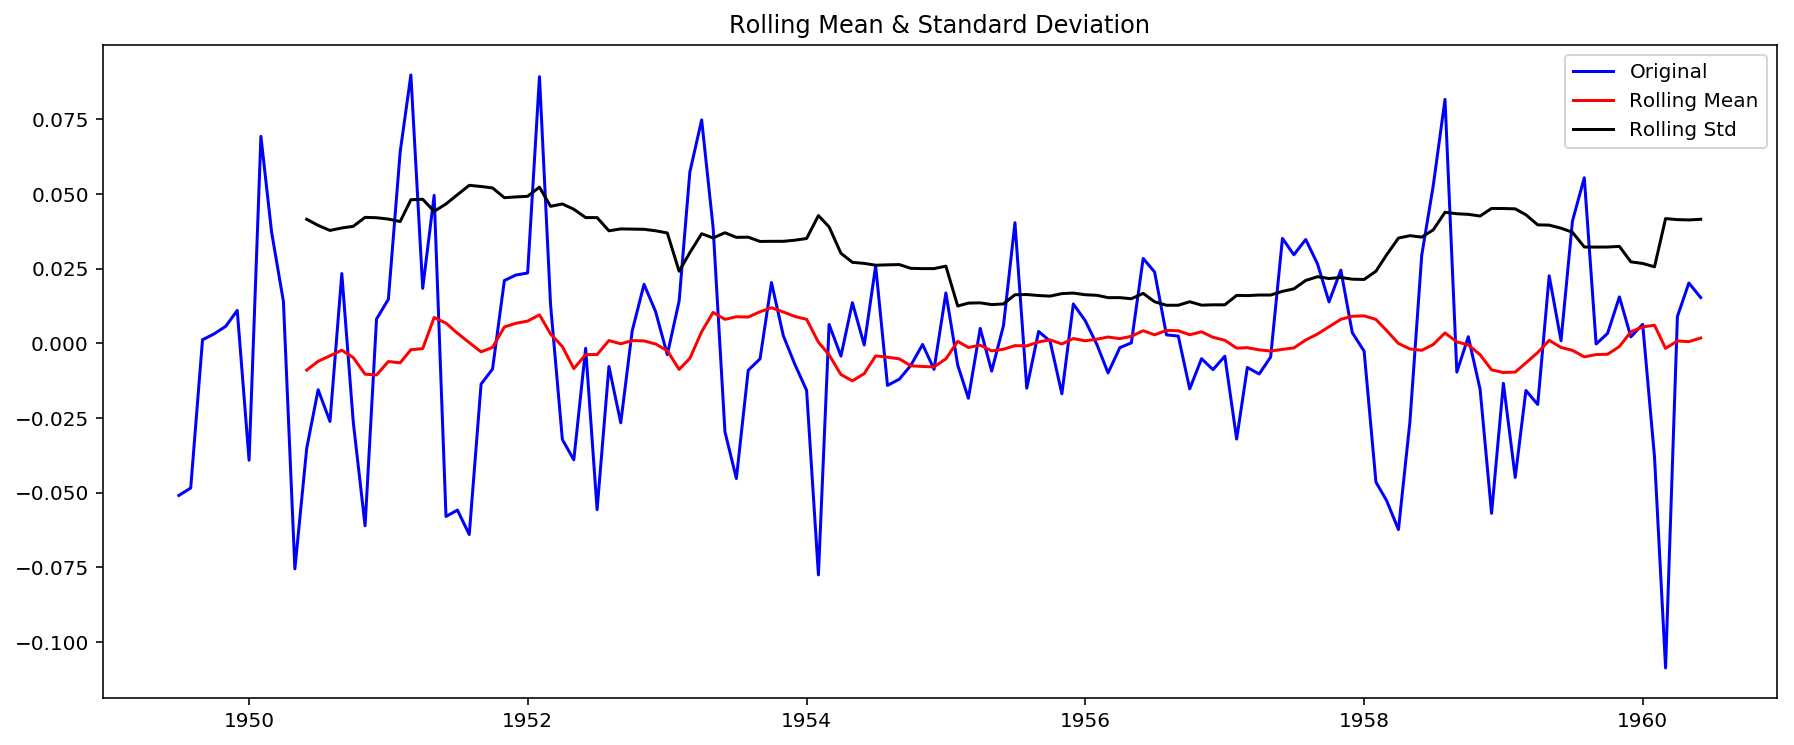

Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


In [82]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

The Dickey-Fuller test statistic is significantly lower than the 1% critical value. So this TS is very close to stationary. We can try advanced decomposition techniques as well which can generate better results. Also, we should note that converting the residuals into original values for future data in not very intuitive in this case.

# Forecasting

Using statistical modeling to forecast the data. **ARIMA** will be used here.<br>
**ARIMA** is a linear equation used for forecasting a stationary time series. The predictors depends on the parameters:<br>
1. Number of Auto-Regressive terms (p)
2. Number of Moving Average terms (q)
3. Number of Differences (d)

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


Text(0.5,1,'RSS: nan')

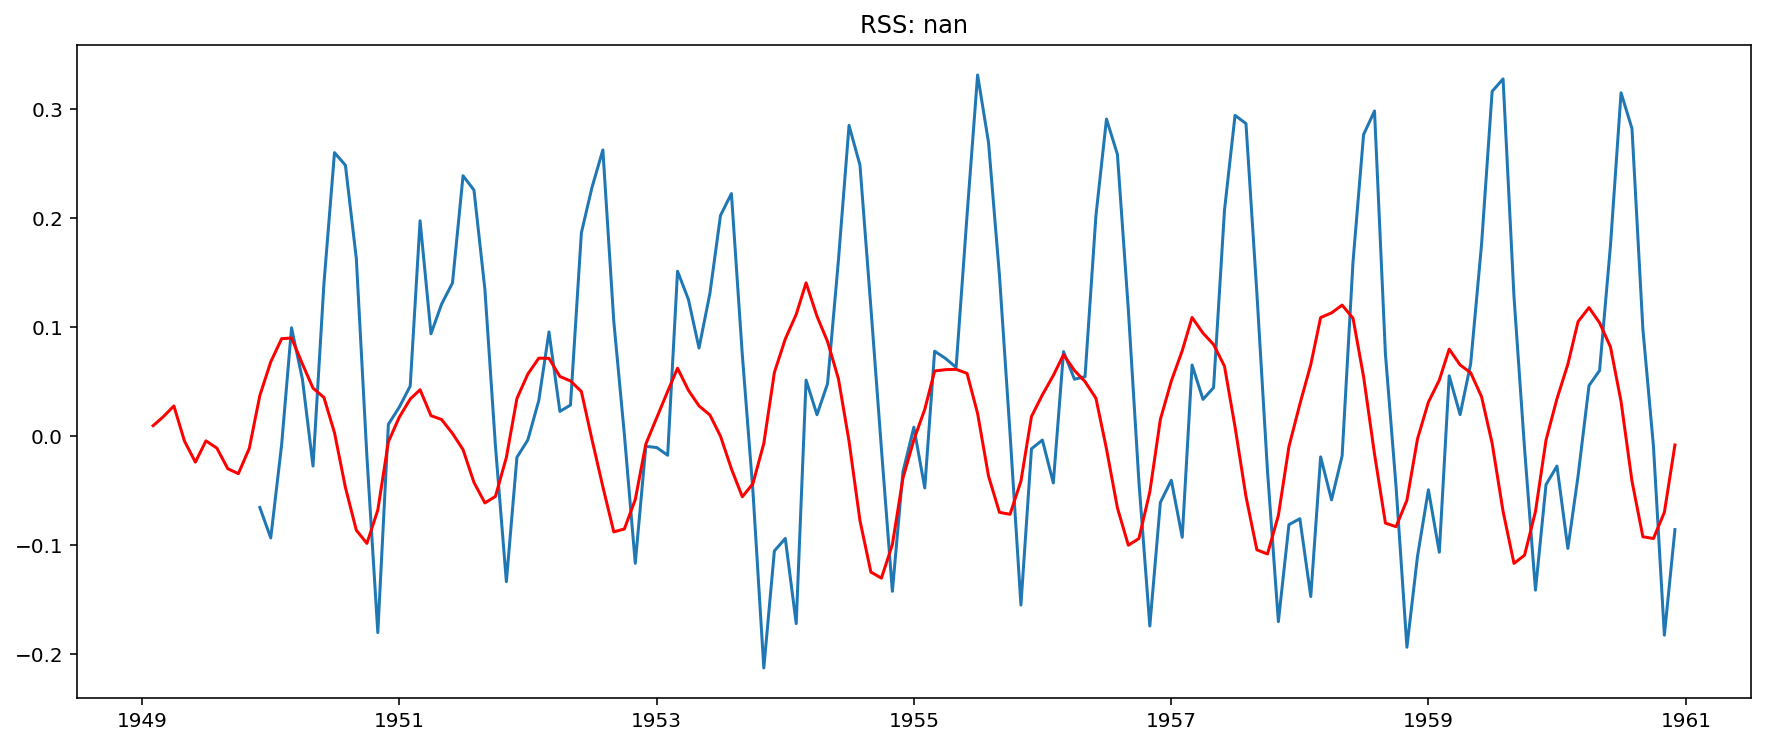

In [85]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(ts_log, order=(2, 1, 2))
results = model.fit(disp=-1)

plt.plot(difference)
plt.plot(results.fittedvalues, color='r')
plt.title('RSS: %.4f' % sum((results.fittedvalues - difference)**2))

# Linear Regression

Will need to recreate the data to properly fit into a Linear Regression model

## ARIMA

In [86]:
predictions = pd.Series(results.fittedvalues, copy=True)
predictions.head()

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
dtype: float64

In [87]:
predictions_cumsum = predictions.cumsum()
predictions_cumsum.head()

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
dtype: float64

In [88]:
predictions_log = pd.Series(ts_log.iloc[0], index=ts_log.index)
predictions_log = predictions_log.add(predictions_cumsum, fill_value=0)
predictions_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64

Text(0.5,1,'RMSE: 90.1046')

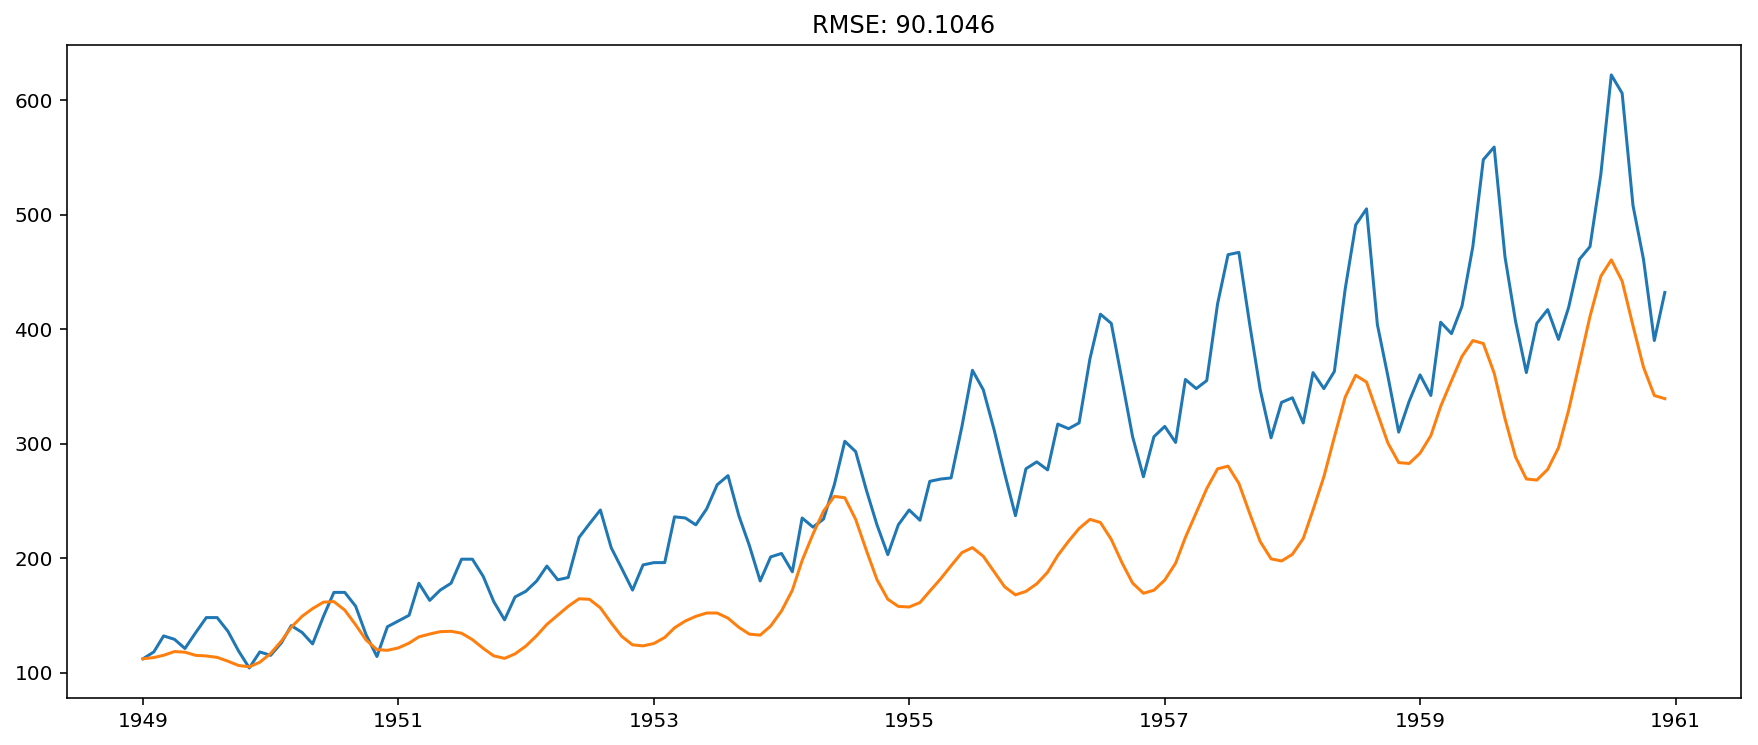

In [90]:
predictions_ARIMA = np.exp(predictions_log)

plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f' % np.sqrt(sum((predictions_ARIMA - ts)**2)/len(ts)))

## SKLearn

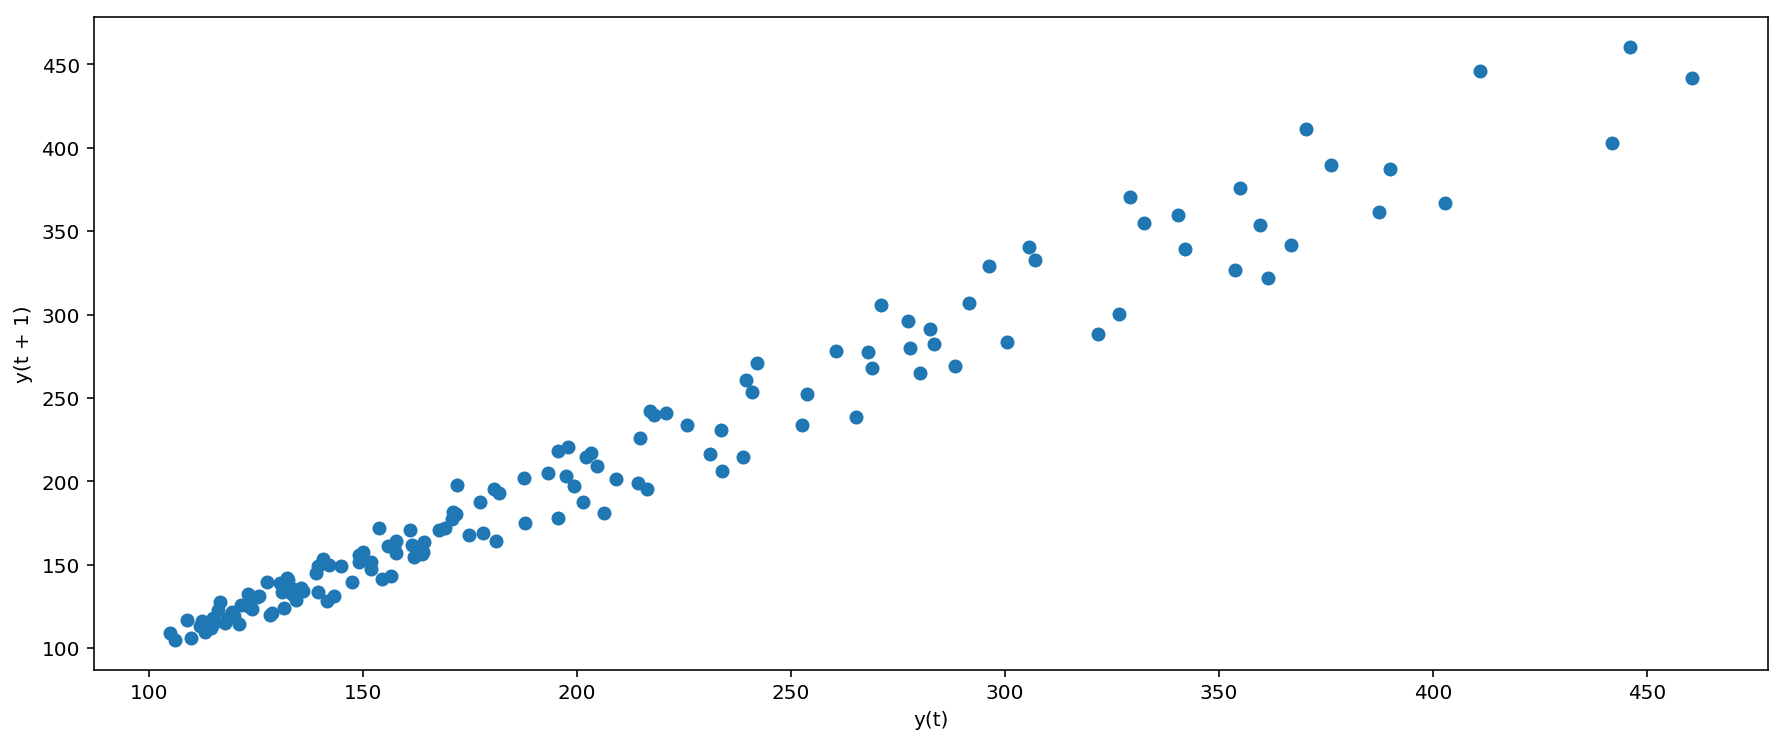

In [94]:
# Quick check using a lag plot to show correlation
from pandas.plotting import lag_plot, autocorrelation_plot
   
ts_lag = lag_plot(predictions_ARIMA)
plt.show()

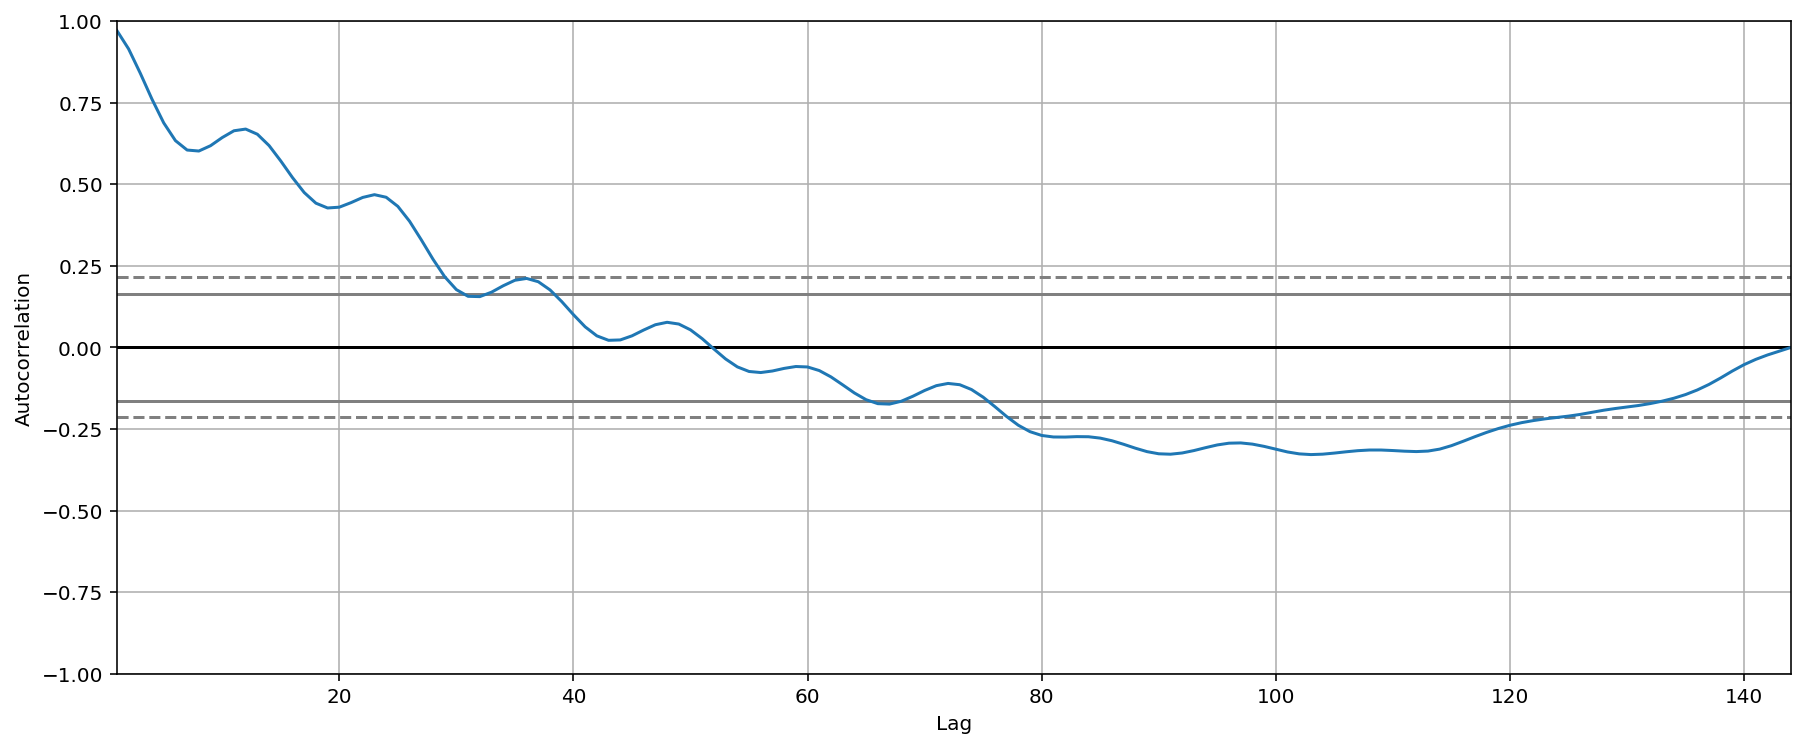

In [95]:
autocorrelation_plot(predictions_ARIMA)
plt.show()

In [96]:
x_data = []
y_data = []
   
for d in range(6,predictions_ARIMA.shape[0]):
    x = predictions_ARIMA.iloc[d-6:d].ravel()
    y = predictions_ARIMA.iloc[d]
    x_data.append(x)
    y_data.append(y)

In [97]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

train, test, label_train, label_test = \
    train_test_split(x_data, y_data, test_size=0.33)

In [98]:
lr = LinearRegression()
lr.fit(train, label_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [99]:
y_pred = lr.predict(test)

Predicted RMSE = 3.8979687109783607


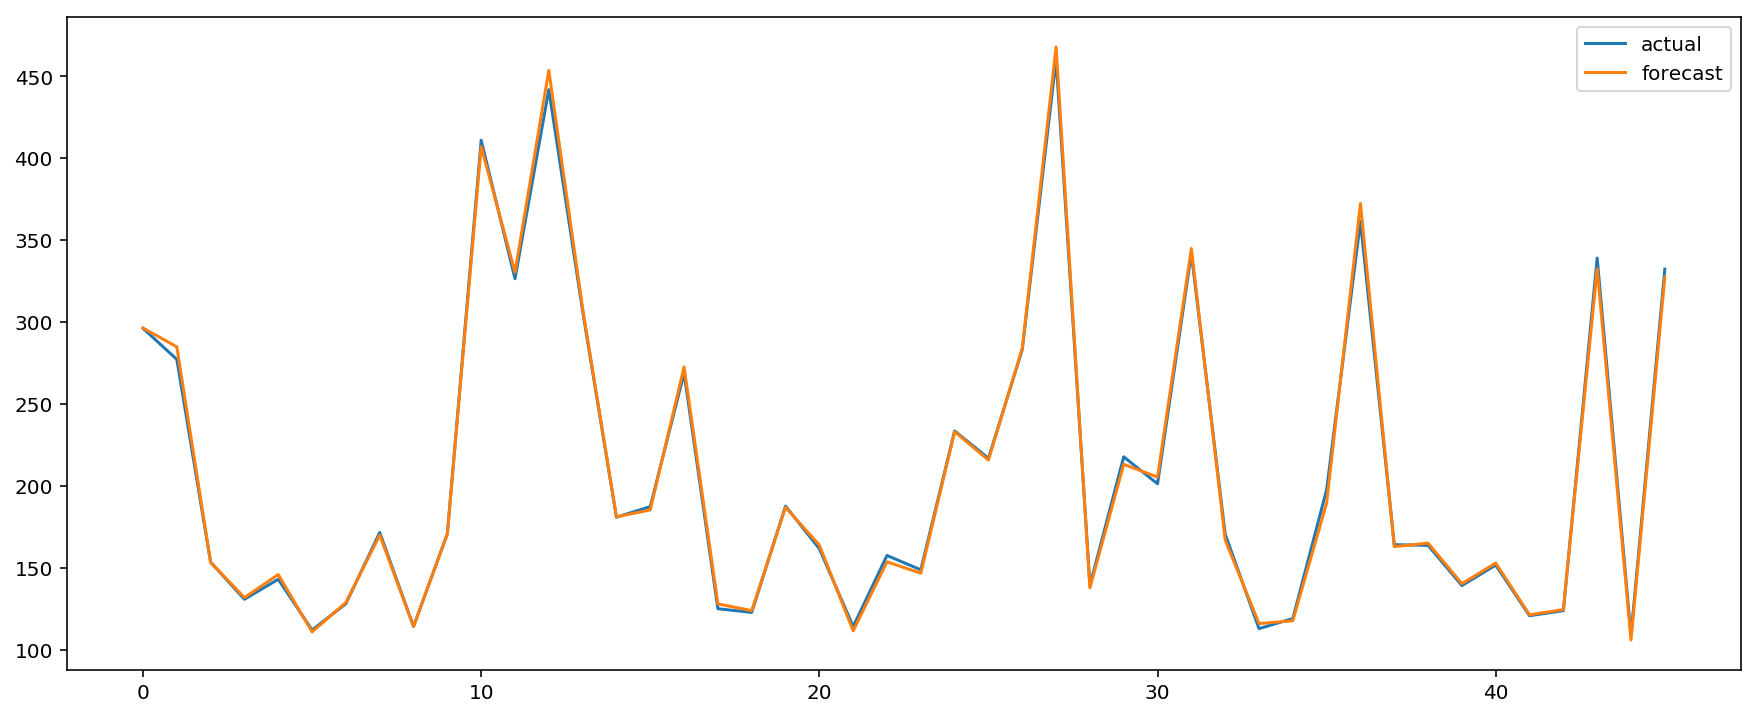

In [100]:
from sklearn.metrics import mean_squared_error

print('Predicted RMSE =', np.sqrt(mean_squared_error(label_test, y_pred)))
plt.plot(np.array(label_test), label='actual')
plt.plot(y_pred, label='forecast')
plt.legend()
plt.show()